In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")
print("Path to dataset files:", path)

Path to dataset files: /home/iamafi/.cache/kagglehub/datasets/ashery/chexpert/versions/1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import timm

import os
import random

from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

In [3]:
DATA_DIR = "/home/iamafi/.cache/kagglehub/datasets/ashery/chexpert/versions/1" 
# DATA_DIR = "/home/iamafi/xray_transformer/CheXpert-v1.0" 

# Set the path to your CSV files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
VALID_CSV = os.path.join(DATA_DIR, "valid.csv")

# Set parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_EPOCHS = 5
LR = 2e-05
GAMMA = 0.7

# Define the device for training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device
print("Device:", DEVICE)

Device: cuda


In [4]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [5]:
# df_train = pd.read_csv(TRAIN_CSV, nrows=50000)
df_train = pd.read_csv(TRAIN_CSV)
df_valid = pd.read_csv(VALID_CSV)

print("Train shape:", df_train.shape)
print("Valid shape:", df_valid.shape)

Train shape: (223414, 19)
Valid shape: (234, 19)


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   No Finding                  22381 non-null   float64
 6   Enlarged Cardiomediastinum  44839 non-null   float64
 7   Cardiomegaly                46203 non-null   float64
 8   Lung Opacity                117778 non-null  float64
 9   Lung Lesion                 11944 non-null   float64
 10  Edema                       85956 non-null   float64
 11  Consolidation               70622 non-null   float64
 12  Pneumonia                   27608 non-null   float64
 13  Atelectasis   

In [7]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Path                        234 non-null    object 
 1   Sex                         234 non-null    object 
 2   Age                         234 non-null    int64  
 3   Frontal/Lateral             234 non-null    object 
 4   AP/PA                       202 non-null    object 
 5   No Finding                  234 non-null    float64
 6   Enlarged Cardiomediastinum  234 non-null    float64
 7   Cardiomegaly                234 non-null    float64
 8   Lung Opacity                234 non-null    float64
 9   Lung Lesion                 234 non-null    float64
 10  Edema                       234 non-null    float64
 11  Consolidation               234 non-null    float64
 12  Pneumonia                   234 non-null    float64
 13  Atelectasis                 234 non

In [8]:
label_columns = ['Cardiomegaly', 'Edema', 'Consolidation', 'Pneumonia', 'No Finding', 'Enlarged Cardiomediastinum', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
                 'Pleural Other', 'Fracture', 'Support Devices', 'Lung Opacity', 'Lung Lesion']
NUM_CLASSES = len(label_columns)

In [9]:
df_train['Path']

0         CheXpert-v1.0-small/train/patient00001/study1/...
1         CheXpert-v1.0-small/train/patient00002/study2/...
2         CheXpert-v1.0-small/train/patient00002/study1/...
3         CheXpert-v1.0-small/train/patient00002/study1/...
4         CheXpert-v1.0-small/train/patient00003/study1/...
                                ...                        
223409    CheXpert-v1.0-small/train/patient64537/study2/...
223410    CheXpert-v1.0-small/train/patient64537/study1/...
223411    CheXpert-v1.0-small/train/patient64538/study1/...
223412    CheXpert-v1.0-small/train/patient64539/study1/...
223413    CheXpert-v1.0-small/train/patient64540/study1/...
Name: Path, Length: 223414, dtype: object

In [10]:
# # Extract image paths and labels
df_train['Path'] = df_train['Path'].apply(lambda x: f"{DATA_DIR}/{x.replace("CheXpert-v1.0-small/", "")}")  # Ensure correct path
df_valid['Path'] = df_valid['Path'].apply(lambda x: f"{DATA_DIR}/{x.replace("CheXpert-v1.0-small/", "")}")  # Ensure correct path

# Extract image paths and labels
# df_train['Path'] = df_train['Path'].apply(lambda x: f"{DATA_DIR}/{x.replace("CheXpert-v1.0/", "")}")  # Ensure correct path
# df_valid['Path'] = df_valid['Path'].apply(lambda x: f"{DATA_DIR}/{x.replace("CheXpert-v1.0/", "")}")  # Ensure correct path


# Replace NaN with 0
df_train[label_columns] = df_train[label_columns].fillna(0).astype(int)  # Replace NaNs and convert to integers
df_valid[label_columns] = df_valid[label_columns].fillna(0).astype(int)  # Replace NaNs and convert to integers

# Replace -1 (uncertain) with 0 (negative)
df_train[label_columns] = df_train[label_columns].replace(-1, 0)
df_valid[label_columns] = df_valid[label_columns].replace(-1, 0)

In [11]:
df_train[label_columns]

,Cardiomegaly,Edema,Consolidation,Pneumonia,No Finding,Enlarged Cardiomediastinum,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Lung Opacity,Lung Lesion
0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,0,0,0,0,0,0,0,0,1,0,0,0,0,0
223410,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223411,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223412,1,0,0,0,0,0,1,0,0,0,0,0,1,0


In [12]:
df_valid[label_columns]

,Cardiomegaly,Edema,Consolidation,Pneumonia,No Finding,Enlarged Cardiomediastinum,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Lung Opacity,Lung Lesion
0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0,0,0,0,0,0,0,0,0,0,0,1,0,0
230,0,0,0,0,0,0,0,0,0,0,0,1,0,0
231,1,1,0,0,0,1,0,0,0,0,0,1,1,0
232,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [13]:
df_train[['Path'] + label_columns].head()

,Path,Cardiomegaly,Edema,Consolidation,Pneumonia,No Finding,Enlarged Cardiomediastinum,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Lung Opacity,Lung Lesion
0,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
df_valid[['Path'] + label_columns].head()

,Path,Cardiomegaly,Edema,Consolidation,Pneumonia,No Finding,Enlarged Cardiomediastinum,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Lung Opacity,Lung Lesion
0,/home/iamafi/.cache/kagglehub/datasets/ashery/...,1,0,0,0,0,1,0,0,0,0,0,0,1,0
1,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,1,0,0,0,1,0,0,0,0,0,0,1,0
4,/home/iamafi/.cache/kagglehub/datasets/ashery/...,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [15]:
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        # Load the image
        image_path = row['Path']
        image = Image.open(image_path).convert('RGB')
        
        # Convert labels to a float tensor
        label = torch.tensor(row[label_columns].values.astype(int), dtype=torch.float32)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [16]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Resize for ViT
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

transform_valid = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Resize for ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [17]:
train_dataset = CheXpertDataset(dataframe=df_train, transform=transform)
valid_dataset = CheXpertDataset(dataframe=df_valid, transform=transform_valid)

In [18]:
from torch.utils.data import DataLoader, random_split

validation_split = 0.15

# Compute split sizes
total_size = len(train_dataset)
val_size = int(total_size * validation_split)
train_size = total_size - val_size

train_subset, valid_subset = random_split(train_dataset, [train_size, val_size])


In [19]:
len(train_subset)

189902

In [20]:
len(valid_subset)

33512

In [21]:
# Create DataLoader instances
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
# valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

# Example: Iterate over the DataLoader
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

for images, labels in valid_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32, 14])
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32, 14])


In [22]:
len(valid_loader)

1048

In [23]:
len(train_loader)

5935

In [25]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

In [26]:
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch

# Load pretrained ViT
# model_name = "google/vit-base-patch16-224"
# model = ViTForImageClassification.from_pretrained(model_name, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True)  # Adjust num_labels

# Processor for ViT
# processor = ViTImageProcessor.from_pretrained(model_name)

model_name = "microsoft/beit-base-patch16-224"
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(label_columns),
    ignore_mismatched_sizes=True
)
processor = AutoImageProcessor.from_pretrained(model_name)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(DEVICE)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Loss function
criterion = nn.BCEWithLogitsLoss()

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([14]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [27]:
def save_model(path):
    # Save the model state dictionary
    torch.save(model.state_dict(), path)
    print(f"Model saved successfully at {path}")

In [28]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_predictions += (preds == labels).float().sum().item()
        total_predictions += labels.numel()

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions * 100
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_predictions += (preds == labels).float().sum().item()
            total_predictions += labels.numel()

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions * 100
    return avg_loss, accuracy

In [29]:
NUM_EPOCHS = 10

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(NUM_EPOCHS):
    print(f"\n🟢 Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, DEVICE)
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)



🟢 Epoch 1/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2970, Train Acc: 87.75%
Valid Loss: 0.2829, Valid Acc: 88.41%

🟢 Epoch 2/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2807, Train Acc: 88.51%
Valid Loss: 0.2781, Valid Acc: 88.67%

🟢 Epoch 3/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2741, Train Acc: 88.78%
Valid Loss: 0.2732, Valid Acc: 88.83%

🟢 Epoch 4/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2692, Train Acc: 88.99%
Valid Loss: 0.2720, Valid Acc: 88.88%

🟢 Epoch 5/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2641, Train Acc: 89.19%
Valid Loss: 0.2702, Valid Acc: 88.95%

🟢 Epoch 6/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2591, Train Acc: 89.40%
Valid Loss: 0.2690, Valid Acc: 88.99%

🟢 Epoch 7/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2543, Train Acc: 89.61%
Valid Loss: 0.2685, Valid Acc: 89.06%

🟢 Epoch 8/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2499, Train Acc: 89.77%
Valid Loss: 0.2679, Valid Acc: 89.11%

🟢 Epoch 9/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2465, Train Acc: 89.91%
Valid Loss: 0.2679, Valid Acc: 89.09%

🟢 Epoch 10/10


  0%|          | 0/5935 [00:00<?, ?it/s]

Train Loss: 0.2448, Train Acc: 89.98%
Valid Loss: 0.2680, Valid Acc: 89.13%


In [30]:
MODEL_WITH_2_CLASSES = "beit_model_with_14_labels.pth"
save_model(MODEL_WITH_2_CLASSES)

Model saved successfully at beit_model_with_14_labels.pth


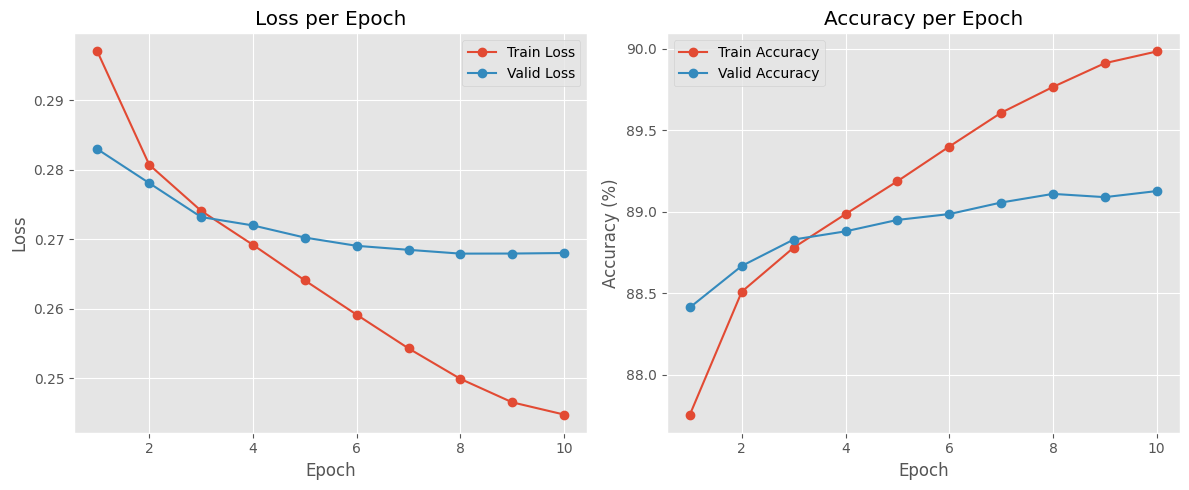

In [31]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, valid_losses, marker='o', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, marker='o', label='Train Accuracy')
plt.plot(epochs, valid_accs, marker='o', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Heatmaps

In [39]:
MODEL_WITH_2_CLASSES = "beit_model_with_14_labels.pth"
# model = ViTForImageClassification.from_pretrained(model_name, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True, output_attentions=True)  # Adjust num_labels
model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=NUM_CLASSES, ignore_mismatched_sizes=True, output_attentions=True)  # Adjust num_labels


if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.to(DEVICE)

model.load_state_dict(torch.load(MODEL_WITH_2_CLASSES))
model.eval()

print("Model loaded successfully.")

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([14]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully.


In [40]:
# Assuming something similar to this:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [41]:

# Let's pick the first image for simplicity
image_tensor = images[9].unsqueeze(0)  # Shape: (1, C, H, W)
image_tensor.shape

torch.Size([1, 3, 224, 224])

In [42]:
labels[9]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.])

In [43]:
with torch.no_grad():
    outputs = model(pixel_values=image_tensor)
    attentions = outputs.attentions  # Tuple: one tensor per transformer block


`BeitSdpaSelfAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [44]:
outputs.logits

tensor([[-2.9121, -1.8231, -1.7685, -4.2711, -4.6523, -3.2623, -2.0438, -1.3210,
          0.9509, -5.9596, -4.2044,  0.8028,  0.9973, -3.8863]],
       device='cuda:0')

In [45]:
preds = (torch.sigmoid(outputs.logits) > 0.5).float()
preds


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.]],
       device='cuda:0')

In [46]:
selected_labels = [label for label, pred in zip(label_columns, preds[0]) if pred == 1]

print(selected_labels)

['Pleural Effusion', 'Support Devices', 'Lung Opacity']


In [47]:
# Last layer, averaging heads
attn_map = attentions[4][0].mean(dim=0)  # [tokens, tokens]
attn_map

tensor([[0.5967, 0.0014, 0.0024,  ..., 0.0042, 0.0018, 0.0015],
        [0.2410, 0.0176, 0.0792,  ..., 0.0062, 0.0133, 0.0111],
        [0.2243, 0.0509, 0.0368,  ..., 0.0044, 0.0086, 0.0036],
        ...,
        [0.2072, 0.0007, 0.0009,  ..., 0.0281, 0.0443, 0.0139],
        [0.2179, 0.0037, 0.0055,  ..., 0.0807, 0.0166, 0.0250],
        [0.2638, 0.0037, 0.0030,  ..., 0.0326, 0.0546, 0.0149]],
       device='cuda:0')

In [48]:
cls_attn = attn_map[0, 1:] 

In [49]:
num_patches = int(cls_attn.shape[0]**0.5)
heatmap = cls_attn.reshape(num_patches, num_patches).cpu().numpy()

# Normalize heatmap to [0, 1]
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

In [50]:
import torchvision.transforms as T

unnorm = T.Normalize(
    mean=[-1, -1, -1],
    std=[1/0.5, 1/0.5, 1/0.5]
)
img_np = unnorm(image_tensor[0].cpu()).permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0, 1)  # Clip values to valid image range

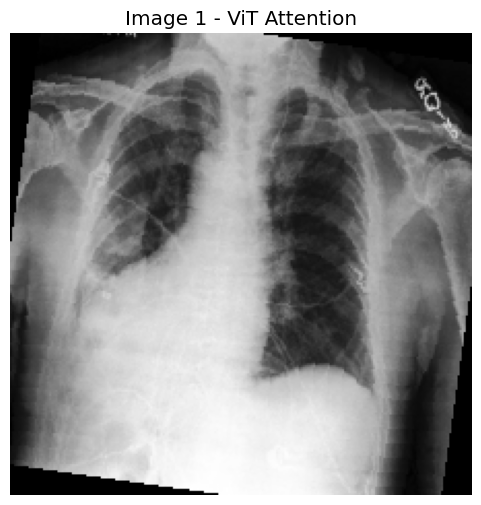

In [51]:
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
# plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Image 1 - ViT Attention")
plt.show()

In [52]:
# Resize the attention heatmap to match the original image size
import cv2
heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

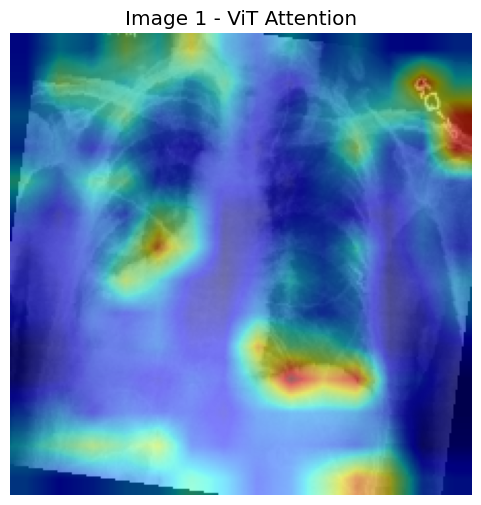

In [53]:
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Image 1 - ViT Attention")
plt.show()